In [1]:
import numpy as np
import pandas as pd
import sys
sys.path.append('/home/potzschf/repos/')
from helperToolz.helper import *
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
res = pd.read_csv('/data/fields/Auxiliary/grid_search/256_20_masked_chipsvrt_GSA-DE_BRB-2019_All_agromask_linecrop_prediction_extent_IoU_hyperparameter_tuning_full.csv')
res[res['field_sizes'] == 1]['IoU']

# Assuming 'res' is your DataFrame
# For visualization, you can create a combined column for 't_ext' and 't_bound'
res['t_ext_t_bound'] = res['t_ext'].astype(str) + ' - ' + res['t_bound'].astype(str)

# Create a boxplot
plt.figure(figsize=(10, 6))  # Set figure size
res['field_sizes'] = res['field_sizes'] / 100
print(res['field_sizes'])
sns.boxplot(data=res, x='t_ext_t_bound', y='field_sizes')

# Add labels and title
plt.title('Field Sizes Distribution per t_ext and t_bound')
plt.xlabel('t_ext - t_bound')
plt.ylabel('Field Size in ha')
# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 10) 
# Show the plot
plt.show()


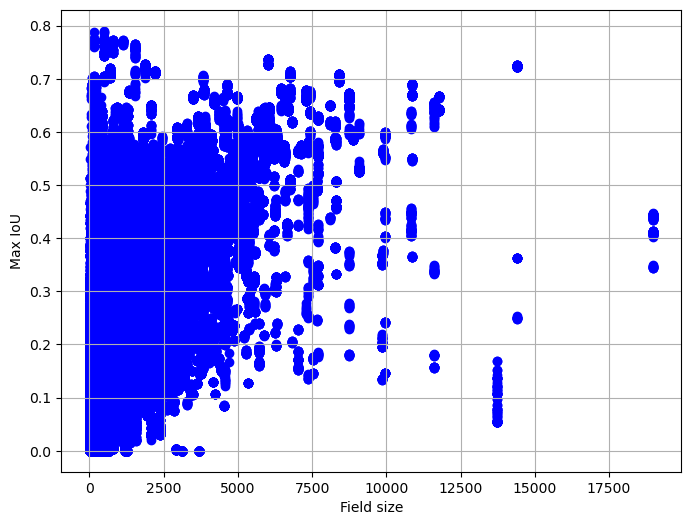

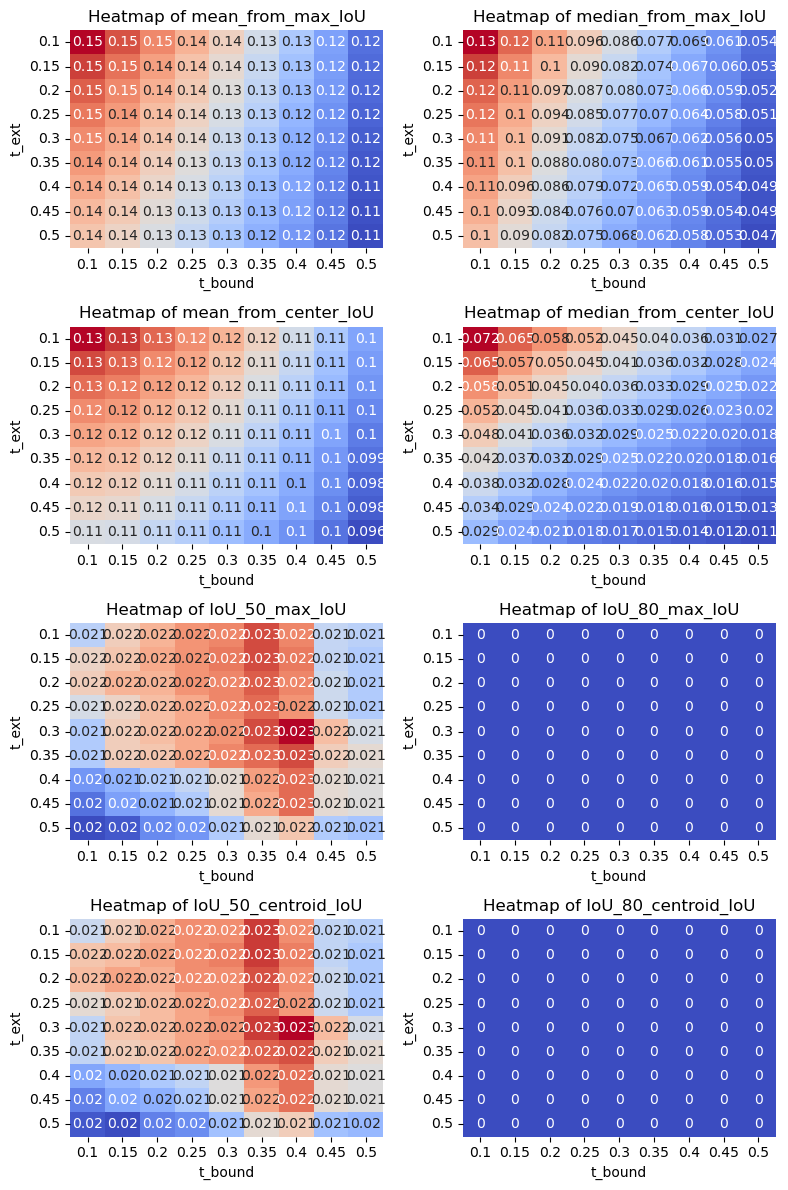

In [ ]:
files = getFilelist('/data/Aldhani/eoagritwin/fields/Auxiliary/grid_search/Brandenburg/256_20_chipsvrt_GSA-DE_BRB-2019_cropMask_lines_touch_false_lines_touch_false_linecrop/', '.csv')
res = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)

filtered_df = res[res['reference_field_sizes'] > 1]

# # Scatter plot
# plt.figure(figsize=(8, 6))
# plt.scatter(filtered_df['reference_field_sizes'], filtered_df['max_IoU'], color='b', marker='o')
# plt.xlabel('Field size')
# plt.ylabel('Max IoU')
# plt.grid(True)
# plt.show()


# # Group by 't_ext' and 't_bound' and calculate the mean and median of IoU
grouped_stats = filtered_df.groupby(['t_ext', 't_bound']).agg({'max_IoU': ['mean', 'median'],
                                                              'centroid_IoU': ['mean', 'median']}).reset_index()
grouped_stats.columns = ['t_ext', 't_bound', 'mean_from_max_IoU', 'median_from_max_IoU', 
                         'mean_from_center_IoU', 'median_from_center_IoU']
# Count IoU values greater than 0.5 and 0.8 and divide by the total count per group
# Define function to calculate IoU ratios (return numeric values)
def calculate_ratios(x):
    ratio_05 = (x > 0.5).sum() / len(x)
    ratio_08 = (x > 0.8).sum() / len(x)
    return pd.Series({'IoU_50': ratio_05, 'IoU_80': ratio_08})

# Columns you want to apply the function to
cols = ['max_IoU', 'centroid_IoU']
conti = []

# Loop over the columns and apply the ratios function
for col in cols:
    # Group by t_ext and t_bound, apply the ratio calculation function
    sub = filtered_df.groupby(['t_ext', 't_bound'])[col].apply(calculate_ratios).reset_index()
    
    # Add a 'metric' column to track which column we are working with
    sub['metric'] = col
    
    sub['level_2'] = sub['level_2'] + '_' + sub['metric']
    sub_df = sub.pivot_table(
        index=["t_ext", "t_bound"],
        columns="level_2",
        values=col
    ).reset_index()
    sub_df.columns.name = None 
    # Append the result to a list of DataFrames
    conti.append(sub_df)

# Concatenate the list of DataFrames into one
combined = pd.concat(conti)

# merge grouped_stats with the 2 calculated columns
merged_df = pd.merge(grouped_stats, combined, on=['t_ext', 't_bound'])
merged_df = merged_df.groupby(['t_ext', 't_bound']).mean().reset_index()


# Assuming merged_df contains the data as described
columns_to_plot = [
    'mean_from_max_IoU', 'median_from_max_IoU',
    'mean_from_center_IoU', 'median_from_center_IoU',
    'IoU_50_max_IoU', 'IoU_80_max_IoU', 
    'IoU_50_centroid_IoU', 'IoU_80_centroid_IoU'
]

# Set up a matplotlib figure for the heatmap layout
plt.figure(figsize=(8, 12))

# Iterate over the columns and create a heatmap for each
for i, column in enumerate(columns_to_plot, start=1):
    # Pivot the DataFrame for the heatmap
    heatmap_data = merged_df.pivot(index='t_ext', columns='t_bound', values=column)

    # Plot the heatmap
    plt.subplot(4, 2, i)  # Adjust the layout for a 2x3 grid
    sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', cbar=False)#cbar_kws={'label': column})
    
    # Title for each heatmap
    plt.title(f'Heatmap of {column}')
    plt.xlabel('t_bound')
    plt.ylabel('t_ext')

plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show()

In [113]:
(res['max_IoU'] == 0).sum() / res.shape[0]

0.08445877847208225

In [9]:
res

,tile,t_ext,t_bound,max_IoU,centroid_IoU,centroid_row,centroid_col,reference_field_IDs,reference_field_sizes
0,0_6,0.1,0.1,0.000593,0.000593,1841,1723,467,4
1,0_6,0.1,0.1,0.218508,0.218508,1959,1605,761,794
2,0_6,0.1,0.1,0.278634,0.278634,2045,1703,983,1442
3,0_6,0.1,0.1,0.057143,0.057143,2073,2130,1305,6
4,0_6,0.1,0.1,0.006944,0.006944,2101,1980,1408,8
...,...,...,...,...,...,...,...,...,...
805054,9_7,0.5,0.5,0.430385,0.430385,1298,594,1727784,1570
805055,9_7,0.5,0.5,0.000000,0.000000,1313,704,1728549,5
805056,9_7,0.5,0.5,0.211292,0.000000,1411,463,1730430,688
805057,9_7,0.5,0.5,0.546453,0.546453,1472,169,1731665,3287


In [ ]:
# # Plot the heatmap
# # Pivot the dataframe to create a matrix for the heatmap
# heatmap_data = res.pivot(index='t_ext', columns='t_bound', values='mean_IoU')

# # Plot the heatmap
# plt.figure(figsize=(8, 6))
# sns.heatmap(heatmap_data, annot=True, cmap='viridis')
# plt.title('Mean IoU Heatmap')
# plt.xlabel('t_bound')
# plt.ylabel('t_ext')
# plt.gca().invert_yaxis()
# plt.show()

# # Scatter plot
# plt.figure(figsize=(8, 6))
# sns.scatterplot(x='t_ext', y='t_bound', size='mean_IoU', data=res, hue='mean_IoU', palette='viridis', sizes=(50, 200))
# plt.title('Scatter Plot of Mean IoU')
# plt.xlabel('t_ext')
# plt.ylabel('t_bound')
# plt.show()